In [2]:
import create_population
import preprocessing
from feature_engineering import FeatureCreator
from feature_engineering_prediction import PredictionFeatureCreator

import prediction

import pandas as pd
import numpy as np



from train_lightgbm_rank_niti import Trainer_lightgbm_rank_niti
from train_lightgbm_time import Trainer_lightgbm_time
from train_lightgbm_rank_kaiki import Trainer_lightgbm_rank_kaiki

from evaluation_lightgbm_rank_niti import Evaluator_lightgbm_rank_niti
from evaluation_lightgbm_time_kaiki import Evaluator_lightgbm_time_kaiki
from evaluation_lightgbm_rank_kaiki import Evaluator_lightgbm_rank_kaiki
from evaluation_pop import Evaluator_pop

%load_ext autoreload

In [3]:
%autoreload

In [4]:
df = pd.read_csv("../data/03_train/evaluation_lightgbm_rank_niti_cv_odds_removed.csv",sep="\t")
df

,race_id,horse_id,target,rank,tansho_odds,popularity,umaban,pred,pred_binary
0,201704020302,2015103838,0,8,49.6,9,10,0.017414,0
1,201704020307,2014101544,0,11,177.9,14,2,0.005378,0
2,201704020302,2015105474,0,6,7.0,3,12,0.044457,0
3,201701010312,2012105639,0,13,104.2,15,10,0.019626,0
4,201701010312,2014106523,0,12,38.9,13,11,0.061182,0
...,...,...,...,...,...,...,...,...,...
119989,202306050907,2020101126,0,13,21.2,8,3,0.056714,0
119990,202306050907,2020103612,0,14,193.8,14,12,0.010119,0
119991,202306050907,2020106546,0,15,35.7,9,7,0.017031,0
119992,202306050907,2017101746,0,16,102.9,11,13,0.043569,0


In [5]:
#期待値
df["expect_return"] = df["tansho_odds"] * df["pred"]
df

,race_id,horse_id,target,rank,tansho_odds,popularity,umaban,pred,pred_binary,expect_return
0,201704020302,2015103838,0,8,49.6,9,10,0.017414,0,0.863752
1,201704020307,2014101544,0,11,177.9,14,2,0.005378,0,0.956819
2,201704020302,2015105474,0,6,7.0,3,12,0.044457,0,0.311202
3,201701010312,2012105639,0,13,104.2,15,10,0.019626,0,2.045063
4,201701010312,2014106523,0,12,38.9,13,11,0.061182,0,2.379998
...,...,...,...,...,...,...,...,...,...,...
119989,202306050907,2020101126,0,13,21.2,8,3,0.056714,0,1.202341
119990,202306050907,2020103612,0,14,193.8,14,12,0.010119,0,1.961067
119991,202306050907,2020106546,0,15,35.7,9,7,0.017031,0,0.608017
119992,202306050907,2017101746,0,16,102.9,11,13,0.043569,0,4.483299


In [7]:
#期待値が1を超えたところにかける
bet_df = df.query("expect_return > 1.0")
bet_df 

,race_id,horse_id,target,rank,tansho_odds,popularity,umaban,pred,pred_binary,expect_return
3,201701010312,2012105639,0,13,104.2,15,10,0.019626,0,2.045063
4,201701010312,2014106523,0,12,38.9,13,11,0.061182,0,2.379998
6,201701010312,2011106102,0,10,20.7,10,3,0.054162,0,1.121161
7,201701010312,2011102827,0,9,101.6,14,2,0.012615,0,1.281730
9,201701010312,2013105962,0,14,24.6,12,7,0.046290,0,1.138742
...,...,...,...,...,...,...,...,...,...,...
119987,202306050907,2018110112,0,11,137.2,12,16,0.009262,0,1.270771
119989,202306050907,2020101126,0,13,21.2,8,3,0.056714,0,1.202341
119990,202306050907,2020103612,0,14,193.8,14,12,0.010119,0,1.961067
119992,202306050907,2017101746,0,16,102.9,11,13,0.043569,0,4.483299


In [9]:
#単勝オッズ（払い戻し）xターゲットは当たったか当たってないか、単勝
#的中率は調べてない、賭け方が1以上の場合にかけているから関係ない
bet_df = bet_df.copy()
bet_df.loc[:, "payoff"] = bet_df["target"] * bet_df["tansho_odds"]

bet_df

,race_id,horse_id,target,rank,tansho_odds,popularity,umaban,pred,pred_binary,expect_return,payoff
3,201701010312,2012105639,0,13,104.2,15,10,0.019626,0,2.045063,0.0
4,201701010312,2014106523,0,12,38.9,13,11,0.061182,0,2.379998,0.0
6,201701010312,2011106102,0,10,20.7,10,3,0.054162,0,1.121161,0.0
7,201701010312,2011102827,0,9,101.6,14,2,0.012615,0,1.281730,0.0
9,201701010312,2013105962,0,14,24.6,12,7,0.046290,0,1.138742,0.0
...,...,...,...,...,...,...,...,...,...,...,...
119987,202306050907,2018110112,0,11,137.2,12,16,0.009262,0,1.270771,0.0
119989,202306050907,2020101126,0,13,21.2,8,3,0.056714,0,1.202341,0.0
119990,202306050907,2020103612,0,14,193.8,14,12,0.010119,0,1.961067,0.0
119992,202306050907,2017101746,0,16,102.9,11,13,0.043569,0,4.483299,0.0


In [10]:
#払い戻しの合計
total_payoff = bet_df["payoff"].sum()
total_payoff

np.float64(38497.2)

In [11]:
#払い戻し、馬券購入回数、回収率
total_bet = len(bet_df)
return_rate = total_payoff / total_bet
total_payoff,total_bet,return_rate

(np.float64(38497.2), 56911, np.float64(0.6764456783398639))

In [12]:
#期待値がどれくらい上になるかを検証
np.linspace(0.8,2,10)

array([0.8       , 0.93333333, 1.06666667, 1.2       , 1.33333333,
       1.46666667, 1.6       , 1.73333333, 1.86666667, 2.        ])

In [13]:
df["payoff"] = df["target"] * df["tansho_odds"]

In [14]:
from collections import defaultdict

result = defaultdict(list)
for exp in np.linspace(0.8,2,100):
    bet_df = df.query(f"expect_return > {exp}")
    total_payoff = bet_df["payoff"].sum()
    total_bet = len(bet_df)
    return_rate = total_payoff / total_bet
    result["expect_return"].append(exp)
    result["total_bet"].append(total_bet)    
    result["total_payoff"].append(total_payoff)
    result["return_rate"].append(return_rate)
result_df = pd.DataFrame(result)
result_df

,expect_return,total_bet,total_payoff,return_rate
0,0.800000,71751,50717.1,0.706849
1,0.812121,70722,50104.5,0.708471
2,0.824242,69715,49164.2,0.705217
3,0.836364,68760,48608.4,0.706928
4,0.848485,67801,47951.8,0.707243
...,...,...,...,...
95,1.951515,21318,13396.2,0.628399
96,1.963636,21088,13207.3,0.626295
97,1.975758,20859,13090.3,0.627561
98,1.987879,20617,12993.1,0.630213


In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

<Axes: xlabel='expect_return', ylabel='return_rate'>

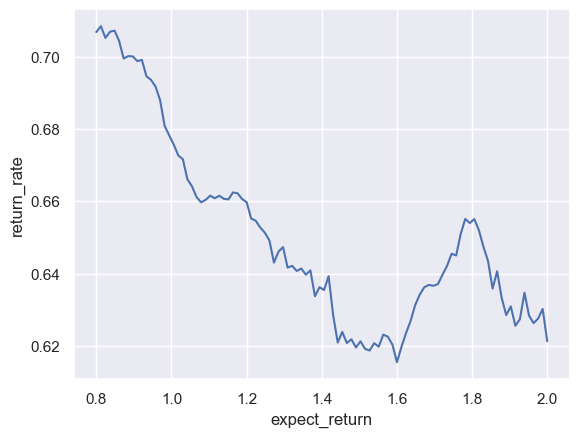

In [16]:
sns.lineplot(result_df,x="expect_return",y="return_rate")

In [17]:
result_df.sort_values("return_rate",ascending = False).head()

,expect_return,total_bet,total_payoff,return_rate
1,0.812121,70722,50104.5,0.708471
4,0.848485,67801,47951.8,0.707243
3,0.836364,68760,48608.4,0.706928
0,0.800000,71751,50717.1,0.706849
2,0.824242,69715,49164.2,0.705217


In [66]:
#他の三連単系にも適応させる
import math
from pathlib import Path

import pandas as pd

DATA_DIR = Path("..", "data")
PREPROCESSED_DIR = DATA_DIR / "01_preprocessed"
TRAIN_DIR = DATA_DIR / "03_train"
OUTPUT_DIR = DATA_DIR / "04_evaluation"
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

return_tables_filepath = PREPROCESSED_DIR / "return_tables.pickle"
train_dir = TRAIN_DIR
evaluation_filename = "evaluation_lightgbm_rank_niti_odds_removed.csv"
output_dir = OUTPUT_DIR
return_tables = pd.read_pickle(return_tables_filepath)
evaluation_df = pd.read_csv(train_dir / evaluation_filename, sep="\t")
output_dir = output_dir
evaluation_df

,race_id,horse_id,target,rank,tansho_odds,popularity,umaban,pred
0,202306030301,2020102181,1,1,1.9,1,12,0.227220
1,202306030301,2020101572,0,2,3.1,2,6,0.308430
2,202306030301,2020102135,0,3,23.4,6,10,0.082764
3,202306030301,2020103975,0,4,6.1,3,13,0.193020
4,202306030301,2020100381,0,5,54.8,7,2,0.019120
...,...,...,...,...,...,...,...,...
35150,202309050912,2017104873,0,12,172.3,13,11,0.008107
35151,202309050912,2019100653,0,13,94.7,12,15,0.013465
35152,202309050912,2017106240,0,14,75.0,10,7,0.029081
35153,202309050912,2018103205,0,15,368.3,15,16,0.009866


In [86]:
"""
sort_colで指定した列でソートし、上位n件のBOX馬券の的中率・回収率を
シミュレーションする関数。
"""
bet_df = (
    evaluation_df.sort_values("pred", ascending = False)
    .groupby("race_id")
    .head(3)
    .groupby("race_id")["umaban"]    
    # 払い戻しテーブルの馬番は文字列型なので合わせる
    .apply(lambda x: list(x.astype(str)))
    .reset_index()
         )
pred_df = (
    evaluation_df.sort_values("pred", ascending = False)
    .sort_values("pred", ascending = False)
    .groupby("race_id")
    .head(3)
    .groupby("race_id")["pred"]
    .apply(lambda x: list(x))
    .reset_index()
)
pred_df

,race_id,pred
0,202301010101,"[0.5077941893501549, 0.3208448203097965, 0.095..."
1,202301010102,"[0.3981832041800139, 0.2223949812396349, 0.092..."
2,202301010103,"[0.2373154014957641, 0.1784663199491415, 0.162..."
3,202301010104,"[0.1677502822473391, 0.1558535863536714, 0.124..."
4,202301010105,"[0.1507361826165545, 0.1198399329579728, 0.119..."
...,...,...
2587,202310030808,"[0.1865958325642172, 0.1520041532233221, 0.090..."
2588,202310030809,"[0.4517475478237358, 0.1288483883944573, 0.101..."
2589,202310030810,"[0.1904262978210795, 0.1258844150211567, 0.112..."
2590,202310030811,"[0.2223973151855648, 0.1828288977248285, 0.171..."


In [90]:
df = bet_df.merge(return_tables, on="race_id")
df = df.merge(pred_df, on="race_id")
df

,race_id,umaban,bet_type,win_umaban,return,pred
0,202301010101,"[5, 8, 1]",単勝,[5],120,"[0.5077941893501549, 0.3208448203097965, 0.095..."
1,202301010101,"[5, 8, 1]",複勝,[5],100,"[0.5077941893501549, 0.3208448203097965, 0.095..."
2,202301010101,"[5, 8, 1]",複勝,[8],110,"[0.5077941893501549, 0.3208448203097965, 0.095..."
3,202301010101,"[5, 8, 1]",複勝,[6],310,"[0.5077941893501549, 0.3208448203097965, 0.095..."
4,202301010101,"[5, 8, 1]",馬連,"[5, 8]",170,"[0.5077941893501549, 0.3208448203097965, 0.095..."
...,...,...,...,...,...,...
28495,202310030812,"[11, 6, 2]",ワイド,"[6, 8]",410,"[0.1658039725112311, 0.1232718706222467, 0.110..."
28496,202310030812,"[11, 6, 2]",ワイド,"[6, 11]",470,"[0.1658039725112311, 0.1232718706222467, 0.110..."
28497,202310030812,"[11, 6, 2]",馬単,"[8, 11]",1580,"[0.1658039725112311, 0.1232718706222467, 0.110..."
28498,202310030812,"[11, 6, 2]",三連複,"[6, 8, 11]",1590,"[0.1658039725112311, 0.1232718706222467, 0.110..."


,race_id,umaban,bet_type,win_umaban,return,pred,numeric_values
0,202301010101,"[5, 8, 1]",単勝,[5],120,"[0.5077941893501549, 0.3208448203097965, 0.095...","[0.5077941893501549, 0.3208448203097965, 0.095..."
1,202301010101,"[5, 8, 1]",複勝,[5],100,"[0.5077941893501549, 0.3208448203097965, 0.095...","[0.5077941893501549, 0.3208448203097965, 0.095..."
2,202301010101,"[5, 8, 1]",複勝,[8],110,"[0.5077941893501549, 0.3208448203097965, 0.095...","[0.5077941893501549, 0.3208448203097965, 0.095..."
3,202301010101,"[5, 8, 1]",複勝,[6],310,"[0.5077941893501549, 0.3208448203097965, 0.095...","[0.5077941893501549, 0.3208448203097965, 0.095..."
4,202301010101,"[5, 8, 1]",馬連,"[5, 8]",170,"[0.5077941893501549, 0.3208448203097965, 0.095...","[0.5077941893501549, 0.3208448203097965, 0.095..."
...,...,...,...,...,...,...,...
28495,202310030812,"[11, 6, 2]",ワイド,"[6, 8]",410,"[0.1658039725112311, 0.1232718706222467, 0.110...","[0.1658039725112311, 0.1232718706222467, 0.110..."
28496,202310030812,"[11, 6, 2]",ワイド,"[6, 11]",470,"[0.1658039725112311, 0.1232718706222467, 0.110...","[0.1658039725112311, 0.1232718706222467, 0.110..."
28497,202310030812,"[11, 6, 2]",馬単,"[8, 11]",1580,"[0.1658039725112311, 0.1232718706222467, 0.110...","[0.1658039725112311, 0.1232718706222467, 0.110..."
28498,202310030812,"[11, 6, 2]",三連複,"[6, 8, 11]",1590,"[0.1658039725112311, 0.1232718706222467, 0.110...","[0.1658039725112311, 0.1232718706222467, 0.110..."


In [ ]:
#期待値
df["expect_return"] = df["return"] * df["pred"]
df

In [94]:
#無理そうだし、期待値が1.78になるくらいの選択肢を評価するのは良さそう
#要するに手動で計算して、その値が出るように